In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
%cd /content/drive/MyDrive/ML_Project

/content/drive/MyDrive/ML_Project


In [19]:
import matplotlib.pyplot as plt
import os, sys
import random
from os import listdir
from PIL import Image

# Dataset creation and description: dataset_young and dataset_old
For this task we need to create two datasets: one containing images of young people and one containing images of elderly people. The concepts of young and old are not rigidly defined: in dataset_young we can find people from the age of 18 to 35 (approximately) and in dataset_old we can have people from 60 to 100 years old.  
The two generated datasets contain 2000 images each; around half of the images in each dataset were taken from bing image search using a script with several keywords. The remaining half were selected from the UTKFace dataset that can be downloaded at [this link](https://archive.org/details/UTKFace).   
Whether the images were downloaded using the script or taken from UTKFace a manual selection of the most pertinent images was performed: images particularly blurred, full-body pictures, images with a lot of clutter and more than one person were removed. The pictures scraped online using the script needed particular care in the selection as the keywords used sometimes grabbed images that were not actually related to the task. The pictures were also selected trying to maintain as much differentiation in gender, ethnicity and face features as possible.


In [ ]:
pip install bing_image_downloader

In [ ]:
from bing_image_downloader import downloader
elderly = ['elderly portrait photography', 'elderly pictures', 'elderly selfie', 'elderly photos', 'old people photography', 'old people face',
           'old actors', 'old actresses', 'elderly actors', 'elderly actresses', 'elderly politicians', 'elderly passport photo',
            'elderly stock']
young = ['women photograpy id', 'man photography id', 'female portrait photography', 'male portrait photography', 'close up face photography',
        'young actors', 'young actresses', 'face model', 'portraits photography', 'ethnic faces']
for keyword_elderly, keyword_young in zip(elderly,young):
    downloader.download(keyword_elderly, limit=100,  output_dir='/scraped_pictures', force_replace=False, timeout=60, verbose=False)
    downloader.download(keyword_young, limit=100,  output_dir='/scraped_pictures', force_replace=False, timeout=60, verbose=False)

After running this script the images are manually selected and added to the folders dataset_old and dataset_young

In [ ]:
#rename all the images in the datasets in a progressive way and make all the images .jpg
def rename_all(directory: str, name: str):
    import os
    mycwd = os.getcwd()
    os.chdir(directory)
    count = 1
    for count, f in enumerate(os.listdir()):
        new_name = name + str(count) + '.jpg'
        os.rename(f, new_name)
    os.chdir(mycwd)

In [ ]:
rename_all('dataset_old', 'dataset_old_')
rename_all('dataset_young', 'dataset_young_')

# Image Visualization
Visualize some ranodm images from the two datasets

In [ ]:
import matplotlib.pyplot as plt
import os, sys
import random
from os import listdir
from PIL import Image

In [ ]:
old = listdir('dataset_old')
young = listdir('dataset_young')

#change all the files extension to jpeg
old_list_change_extension = [i for i in old if not i.endswith('.jpeg')]
young_list_change_extension = [i for i in young if not i.endswith('.jpeg')]

for o, y in zip(old_list_change_extension, young_list_change_extension):
  #change all the extensions in dataset_old
  path_o='dataset_old/'
  base_o = os.path.splitext(o)[0]
  os.rename(path_o + o, path_o + base_o + '.jpeg')
  #change all the extensions in dataset_young
  path_y='dataset_young/'
  base_y = os.path.splitext(y)[0]
  os.rename(path_y + y, path_y + base_y + '.jpeg')

#load all the images in lists
old_list = [i for i in old if i.endswith('.jpeg')]
young_list = [i for i in young if i.endswith('.jpeg')]

In [ ]:
#check if both the lists have 2000 elements
print(len(old_list))
print(len(young_list))

2000
2000


Text(0.5, 0.98, 'Samples from Dataset_old')

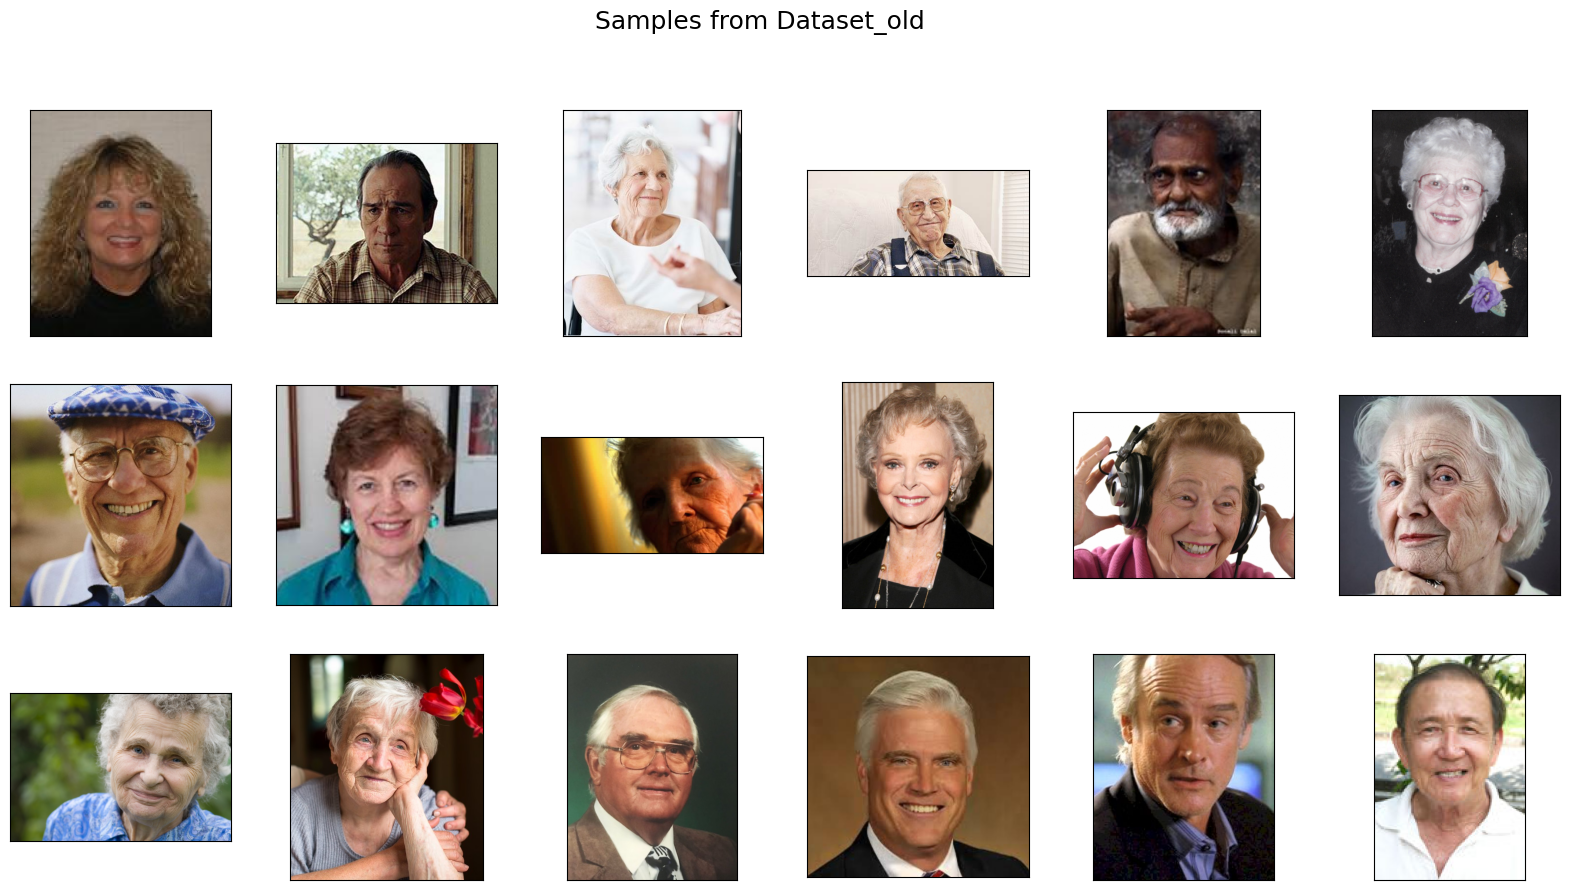

In [ ]:
#create subplot with 18 images for elderly people
show_old = random.sample(old_list, 18)
fig, axs = plt.subplots(nrows=3, ncols=6, figsize=(20, 10))
path = 'dataset_old/'
axs = axs.flatten()
for i, image_name in enumerate(show_old):
    image_name = path + image_name
    pic = plt.imread(image_name)
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)
    axs[i].imshow(pic)
fig.suptitle('Samples from Dataset_old', fontsize=18)

Text(0.5, 0.98, 'Samples from Dataset_young')

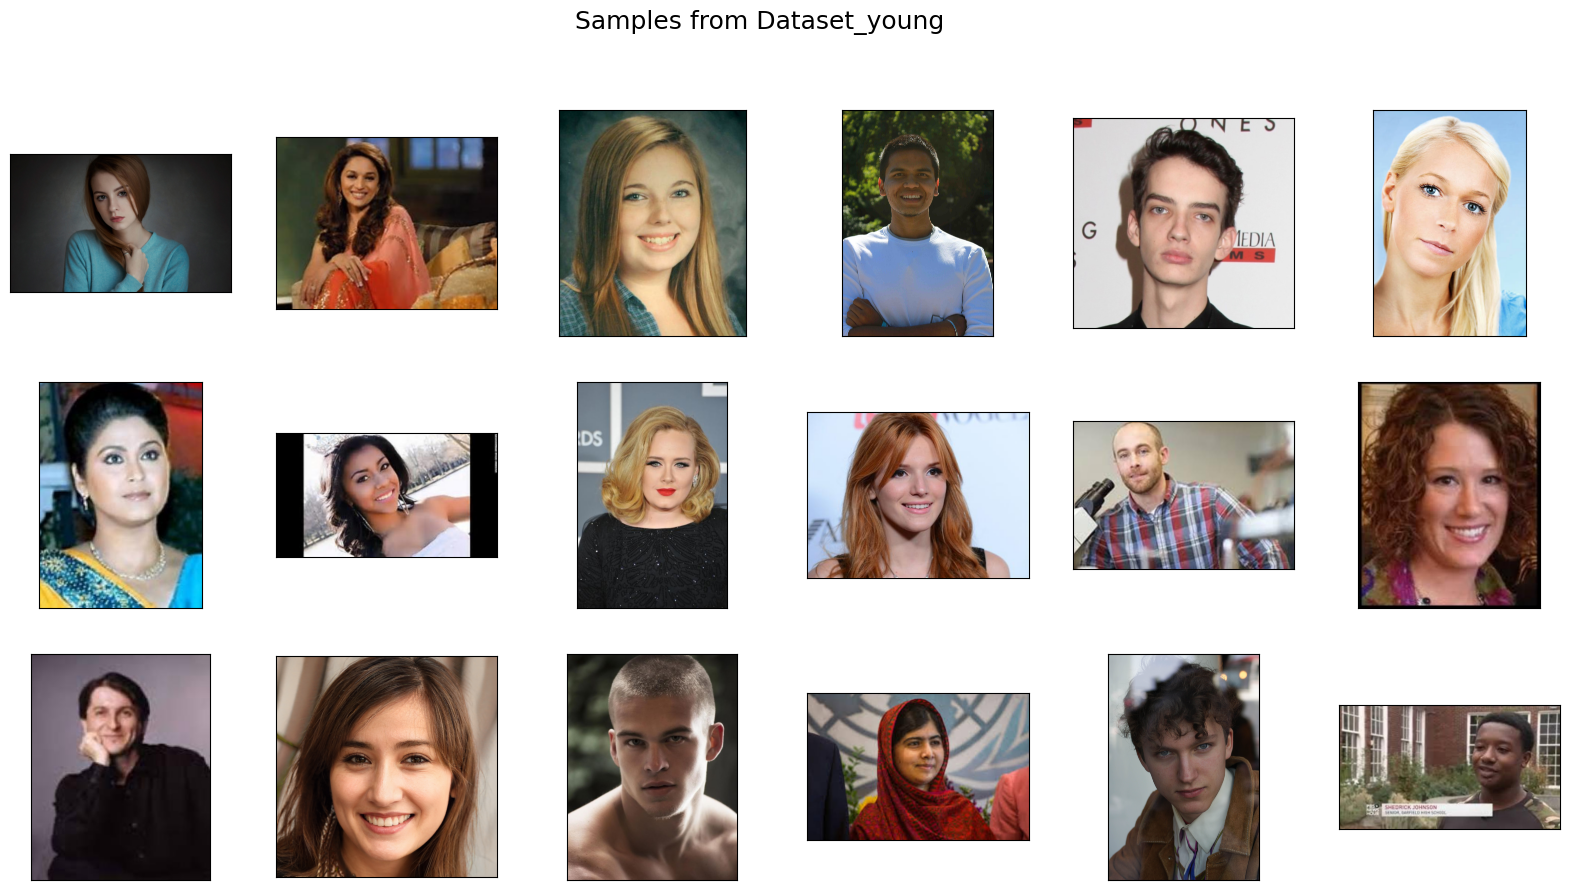

In [ ]:
#create subplot with 18 images for young people
show_young = random.sample(young_list, 18)
fig, axs = plt.subplots(nrows=3, ncols=6, figsize=(20, 10))
path = 'dataset_young/'
axs = axs.flatten()
for i, image_name in enumerate(show_young):
    image_name = path + image_name
    pic = plt.imread(image_name)
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)
    axs[i].imshow(pic)
fig.suptitle('Samples from Dataset_young', fontsize=18)

# Face Extraction
Even after a manual cut of the images that are not suitable for this task, every image has it's own shape and dimension, the faces contained in the pictures could be in the upper half or lower, in a corner or at the center. The faces could be very close up or very far. The images are very different in terms of dimensions as well so a resizing of every image needs to be performed before training the GAN.  
Some images are vertical and may contain the upper body of the person along with the face, some images instead are more horizontal and may contain more than one person or several distracting elements. Resizing these kind of images will result almost certainly to a distortion of the depicted face.
For this reason I decided to extract the faces from the images and create new images that only contain the face of the people depicted. To perform this task I used [this github folder](https://github.com/kb22/Create-Face-Data-from-Images). The project in the linked folder uses OpenCV's Face Detection Neural Network to detect faces in images and can perform two tasks: create an image identical to the input where there is a rectangle around the face (data_generator.py), create an image that only contains the extracted face (face_extractor.py).  
For the purpose of my project I created a face_extractor_mine.py in which the code is very similar to the original one but I edited some of features:
- I added a parser function that allows us to set from command line an input and output folder for the images and the choice to execute the original code or my version
- I added an exception handler in the code section that saves the images in case that the script can't open a file
- I made it so that the saved images do not contain exclusively the face but a bigger picture around the face that includes a few more elements from the original picture.  

This last choice is driven by the fact that the model used is very strict in selecting the face: it shows just above the eyes and just below the mouth. In most cases it completely cuts hair and chin and in some cases ears as well. I don't want the network to focus too much on useless details but training with images like those could compromise the performances as well.
Below I will show the difference between the original cut and the image obtained with my version of the code.

## Extraction examples from dataset_old

In [ ]:
#from the example folder that contains 5 images extract the face with the original code
!python extract_faces/face_extractor_mine.py --original=1 --input_folder='examples/' --output_folder='examples/examples_output_original/'

Extracted 5 faces from all images


In [ ]:
#from the example folder that contains 5 images extract the face with my version
!python extract_faces/face_extractor_mine.py --original=0 --input_folder='examples/' --output_folder='examples/examples_output_mine/'

Extracted 5 faces from all images


In [36]:
input_pictures = listdir('examples/')
input_pictures_list = [i for i in input_pictures if i.endswith('.jpg')] #use endswith to exclude the folders in examples
original = listdir('examples/examples_output_original/')
original_list = [i for i in original if i.endswith('.jpg')]
mine = listdir('examples/examples_output_mine/')
mine_list = [i for i in mine if i.endswith('.jpg')]

In [37]:
def loop_subplot (path:str, images_list: list, nrows: int, ncols: int, figsize: tuple, title: str = None):
  fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
  axs = axs.flatten()
  for i, image_name in enumerate(images_list):
      image_name = path + image_name
      pic = plt.imread(image_name)
      axs[i].get_xaxis().set_visible(False)
      axs[i].get_yaxis().set_visible(False)
      axs[i].imshow(pic)
  fig.suptitle(title, fontsize=18)

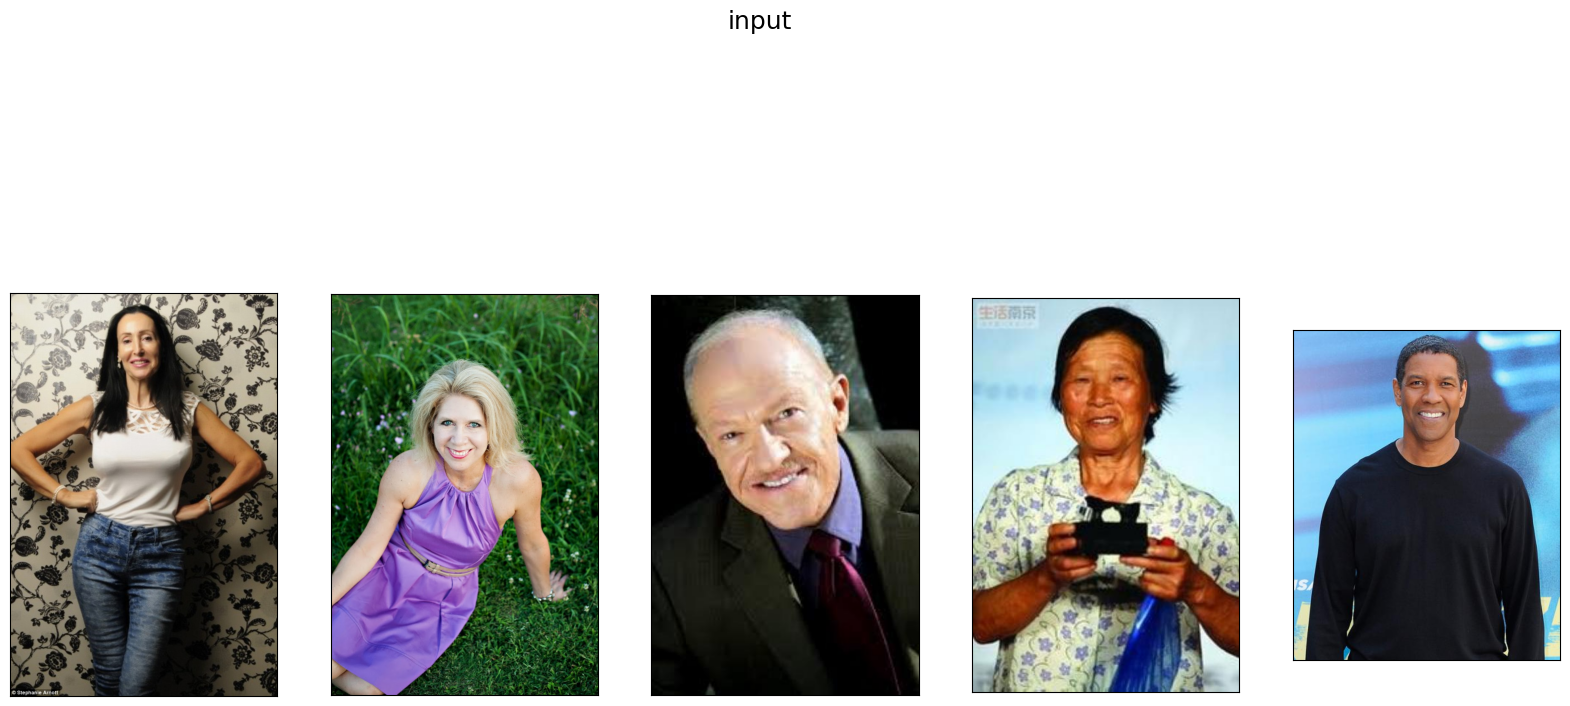

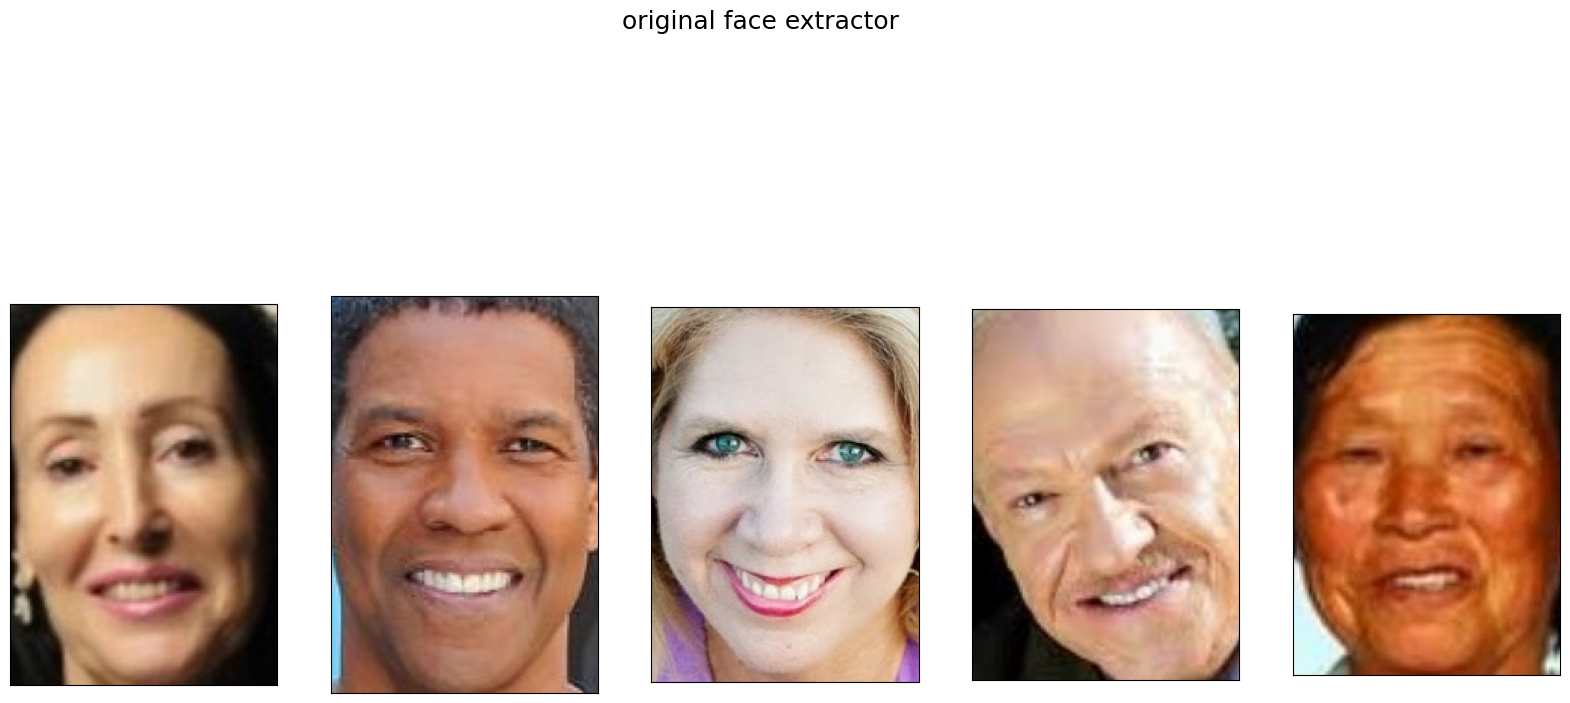

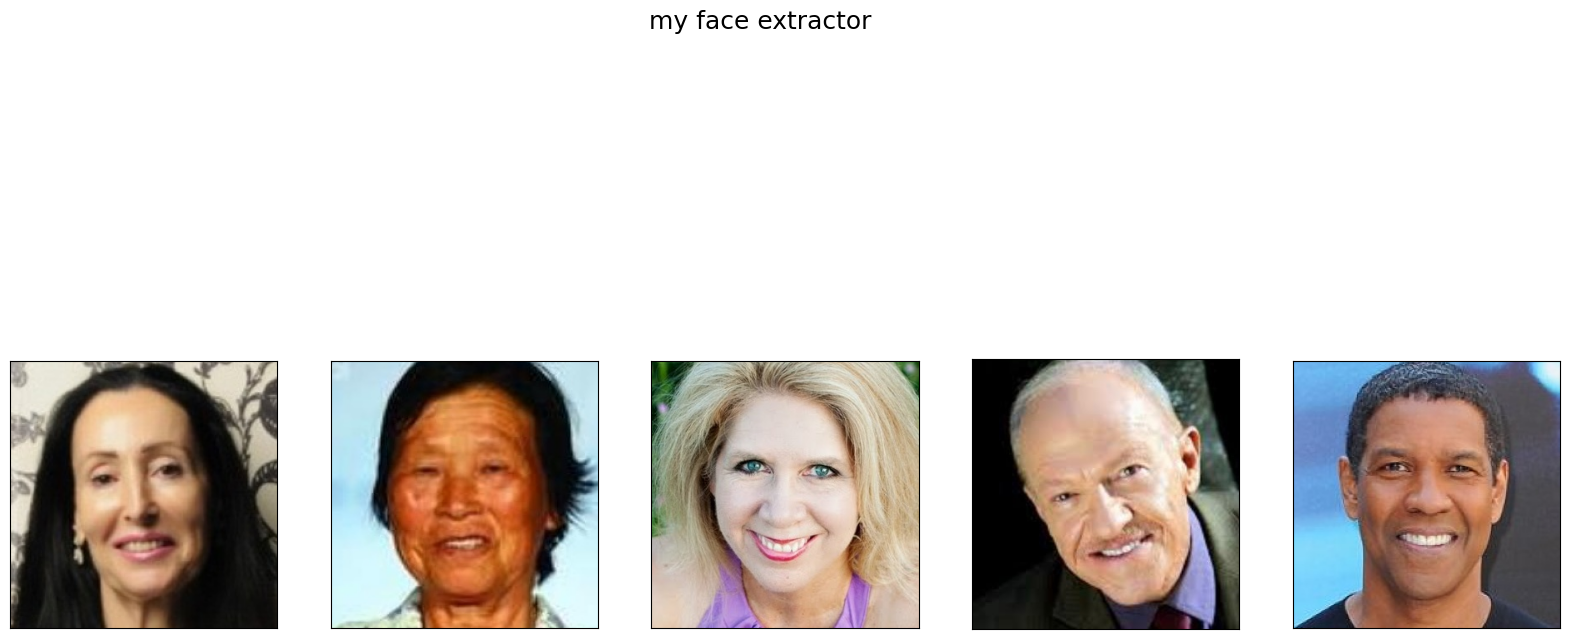

In [39]:
loop_subplot('examples/', input_pictures_list, 1, 5, figsize=(20,10), title='input')
loop_subplot('examples/examples_output_original/', original_list, 1, 5, figsize=(20,10), title='original face extractor')
loop_subplot('examples/examples_output_mine/', mine_list, 1, 5, figsize=(20,10), title='my face extractor')

The images obtained with the second method are more similar to what we would like to have as a training dataset: they are much more similar to each other, almost always square (so when we will perform the risize the faces will not be distorted) and most of the distracting elements are excluded from the pictures. Now we will perform this operation on both the datasets.  
NB: some images from the input datasets could not be opened with the script so those images were added by hand.

## Extraction examples from dataset_young


In [ ]:
#from the example folder that contains 5 images extract the face with the original code
!python extract_faces/face_extractor_mine.py --original=1 --input_folder='examples_young/' --output_folder='examples_young/examples_output_original/'

Extracted 5 faces from all images


In [ ]:
#from the example folder that contains 5 images extract the face with my version
!python extract_faces/face_extractor_mine.py --original=0 --input_folder='examples_young/' --output_folder='examples_young/examples_output_mine/'

Extracted 5 faces from all images


In [32]:
input_pictures = listdir('examples_young/')
input_pictures_list = [i for i in input_pictures if i.endswith('.jpg')] #use endswith to exclude the folders in examples
original = listdir('examples_young/examples_output_original/')
original_list = [i for i in original if i.endswith('.jpg')]
mine = listdir('examples_young/examples_output_mine/')
mine_list = [i for i in mine if i.endswith('.jpg')]

In [33]:
def loop_subplot (path:str, images_list: list, nrows: int, ncols: int, figsize: tuple, title: str = None):
  fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
  axs = axs.flatten()
  for i, image_name in enumerate(images_list):
      image_name = path + image_name
      pic = plt.imread(image_name)
      axs[i].get_xaxis().set_visible(False)
      axs[i].get_yaxis().set_visible(False)
      axs[i].imshow(pic)
  fig.suptitle(title, fontsize=18)

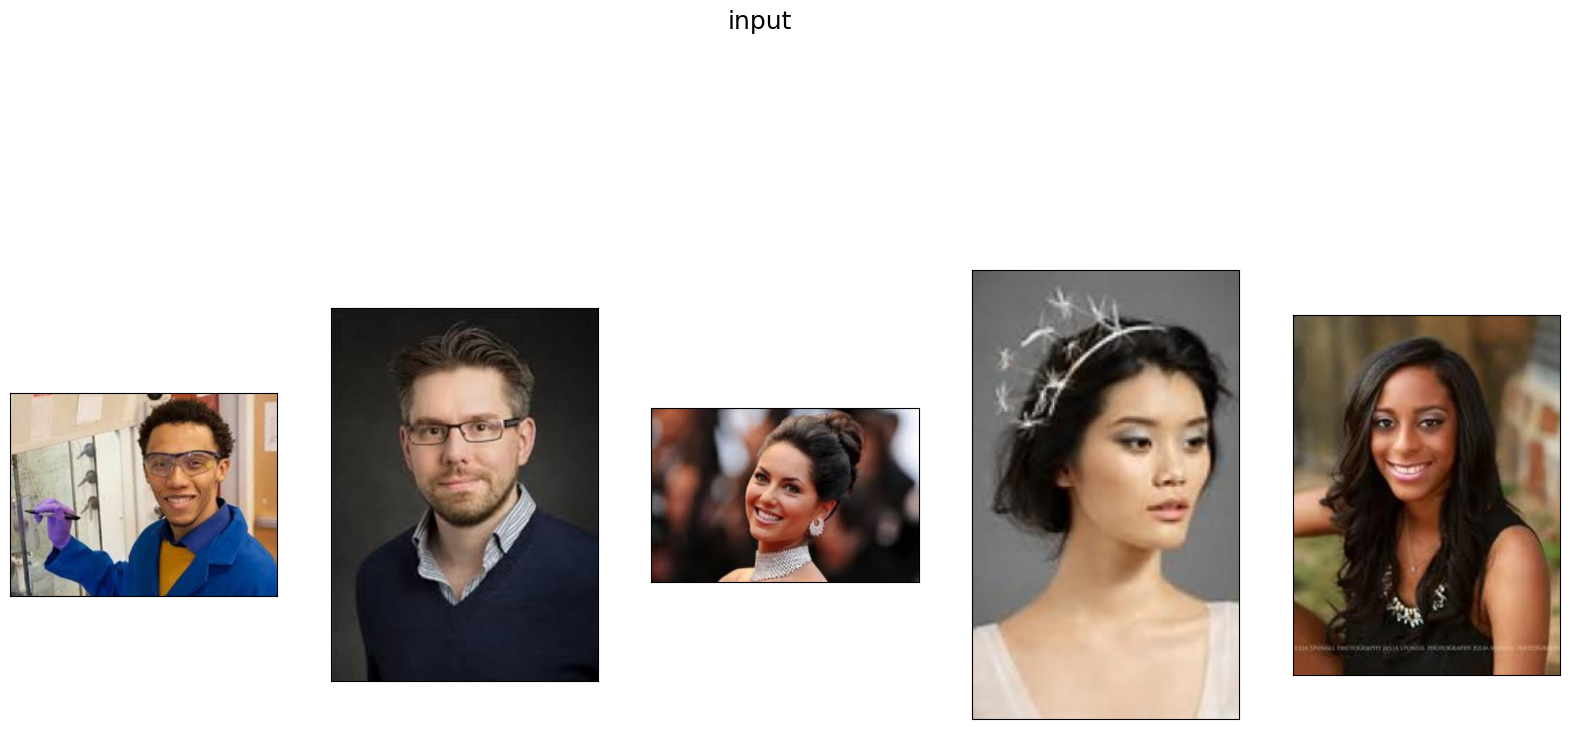

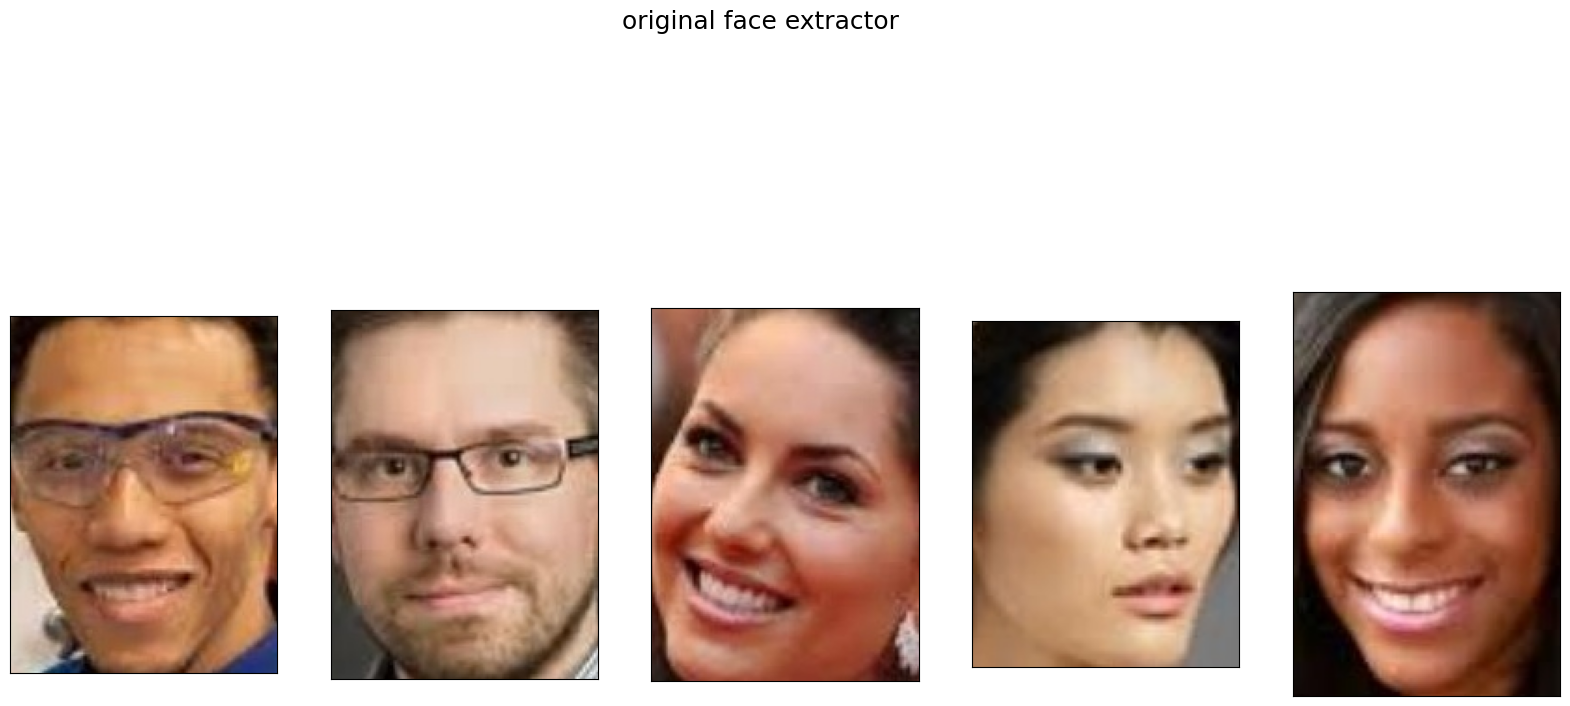

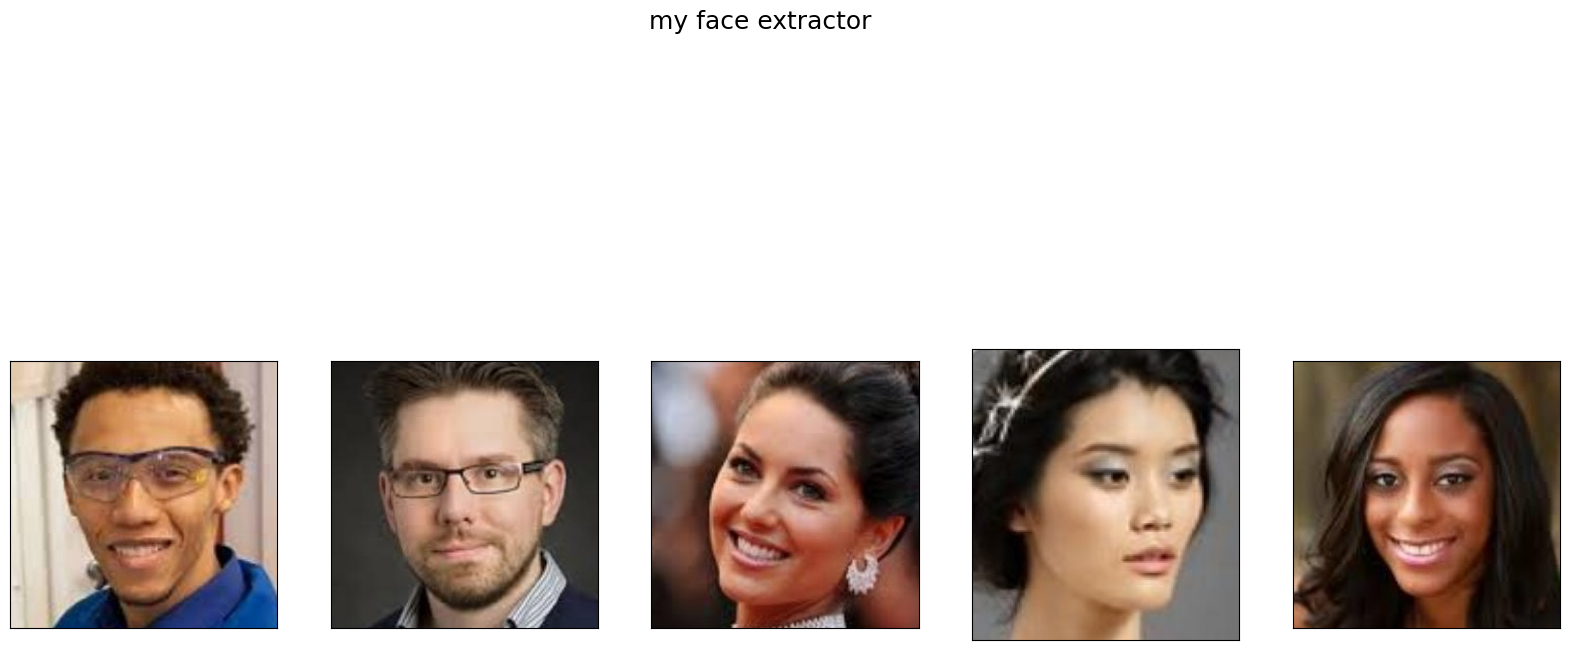

In [35]:
loop_subplot('examples_young/', input_pictures_list, 1, 5, figsize=(20,10), title='input')
loop_subplot('examples_young/examples_output_original/', original_list, 1, 5, figsize=(20,10), title='original face extractor')
loop_subplot('examples_young/examples_output_mine/', mine_list, 1, 5, figsize=(20,10), title='my face extractor')

The images obtained with the second method are more similar to what we would like to have as a training dataset: they are much more similar to each other, almost always square (so when we will perform the risize the faces will not be distorted) and most of the distracting elements are excluded from the pictures. Now we will perform this operation on both the datasets.  
NB: some images from the input datasets could not be opened with the script so those images were added by hand.

## Complete dataset extraction


In [ ]:
!python extract_faces/face_extractor_mine.py --original='False' --input_folder='dataset_old/' --output_folder='dataset_old_faces/'

In [ ]:
!python extract_faces/face_extractor_mine.py --original='False' --input_folder='dataset_young/' --output_folder='dataset_young_faces/'